In [ ]:
#Importing Libraries:

import findspark
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
#Initializing findspark:
findspark.init()

In [ ]:
#Importing pyspark libraries:

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *

In [ ]:
#Connection between spark and Mongo DB 

spark = SparkSession.builder.appName("myApp").config("spark.mongodb.input.uri","mongodb://localhost:27017/Rest.Rest?readPreference=primaryPreferred").config("spark.mongodb.output.uri","mongodb://localhost:27017/Rest.Rest").config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").getOrCreate()

In [ ]:
#Fetching the data from url and creating spark context

url="https://raw.githubusercontent.com/gayatripandit006/CDAC--DBDA-Project/main/Restaurant_Reviews_Raw.txt"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
SparkFiles.get("Restaurant_Review_Raw.txt")



'C:\\Users\\AKRITI GUPTA\\AppData\\Local\\Temp\\spark-99cadfa4-2fd1-484e-a3ec-9003ca7cb3e0\\userFiles-7d9b266d-967c-4fd0-8c7b-09edfd2f0eb5\\Restaurant_Review_Raw.txt'

In [ ]:
#Reading the file through spark:

raw_dataset=spark.read.option("delimiter", "\t").csv("Restaurant_Review_Raw.txt",header=True)

In [ ]:
#Dataframe 1:
raw_dataset.show()

+---------------+--------------------+--------------------+------+--------------------+--------------------+--------+
|     Restaurant|            Reviewer|              Review|Rating|            Metadata|                Time|Pictures|
+---------------+--------------------+--------------------+------+--------------------+--------------------+--------+
|Beyond Flavours|   Rusha Chakraborty|The ambience was ...|     5|1 Review . 2 Foll...|5/25/2019  3:54:0...|       0|
|Beyond Flavours|Anusha Tirumalaneedi|Ambience is too g...|     5|3 Reviews . 2 Fol...|5/25/2019  2:20:0...|       0|
|Beyond Flavours|     Ashok Shekhawat|A must try.. grea...|     5|2 Reviews . 3 Fol...|5/24/2019  10:54:...|       0|
|Beyond Flavours|      Swapnil Sarkar|Soumen das and Ar...|     5|1 Review . 1 Foll...|5/24/2019  10:11:...|       0|
|Beyond Flavours|              Dileep|Food is good.we o...|     5|3 Reviews . 2 Fol...|5/24/2019  9:37:0...|       0|
|Beyond Flavours|       Nagabhavani K|Ambiance is good..

In [ ]:
#Count of rows in original dataset:

raw_dataset.count()

10001

In [ ]:
#Exporting raw data to MongoDB
raw_dump = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.Raw_data").load()
raw_dataset.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.raw_data").save()

In [ ]:
#Splitting the data into two subsets:
#Dataframe 1: ['Restaurant', 'Review']
raw_dataset.drop("Reviewer","Rating","MetaData","Time","Pictures") \
    .printSchema()

cols = ("Reviewer","Rating","MetaData","Time","Pictures")

#New Dataframe 1:
df1 = raw_dataset.drop(*cols)


root
 |-- Restaurant: string (nullable = true)
 |-- Review: string (nullable = true)



In [ ]:
#Check Null Values if exist any: (Before dropping)

checkNullValues = {col:df1.filter(df1[col].isNull()).count() for col in df1.columns}
print(checkNullValues)

{'Restaurant': 0, 'Review': 45}


In [ ]:
#Filtering out null values:

df1.filter(col("Review").isNull()).show()

+-------------------+------+
|         Restaurant|Review|
+-------------------+------+
|               Amul|  null|
|       Being Hungry|  null|
|    Hyderabad Chefs|  null|
|    Hyderabad Chefs|  null|
|       Olive Garden|  null|
| Al Saba Restaurant|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
+-------------------+------+
only showing top 20 rows



In [ ]:
### Drop rows with Null values with where condition:
 
drop_1 = df1.where(col('Review').isNotNull())
drop_1.show()

+---------------+--------------------+
|     Restaurant|              Review|
+---------------+--------------------+
|Beyond Flavours|The ambience was ...|
|Beyond Flavours|Ambience is too g...|
|Beyond Flavours|A must try.. grea...|
|Beyond Flavours|Soumen das and Ar...|
|Beyond Flavours|Food is good.we o...|
|Beyond Flavours|Ambiance is good....|
|Beyond Flavours|Its a very nice p...|
|Beyond Flavours|Well after readin...|
|Beyond Flavours|Excellent food . ...|
|Beyond Flavours|Came for the birt...|
|Beyond Flavours|The service was g...|
|Beyond Flavours|Very good ambienc...|
|Beyond Flavours|Food was very goo...|
|Beyond Flavours|Food is too good....|
|Beyond Flavours|We ordered corn c...|
|Beyond Flavours|Food and ambience...|
|Beyond Flavours|Came here for lun...|
|Beyond Flavours|The best thing ab...|
|Beyond Flavours|Polite and friend...|
|Beyond Flavours|Food is really go...|
+---------------+--------------------+
only showing top 20 rows



In [ ]:
#Check Null Values if exist any: (After dropping)

checkNullValues = {col:drop_1.filter(drop_1[col].isNull()).count() for col in drop_1.columns}
print(checkNullValues)

{'Restaurant': 0, 'Review': 0}


In [ ]:
drop_1.count()

9956

In [ ]:
# Remove leading and trailing spaces in columns:
from pyspark.sql.functions import trim
drop_1.withColumn("Restaurant",trim(col("Restaurant"))).show(5, truncate = False)


+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Restaurant     |Review                                                                                                                                                                                       |
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Beyond Flavours|The ambience was good. food was quite good . had Saturday lunch . which was cost effective .                                                                                                 |
|Beyond Flavours|Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service       

In [ ]:
#Distinct Count of Restaurant Column:

from pyspark.sql.functions import countDistinct
distinct_count=drop_1.select(countDistinct("Restaurant"))
distinct_count.show()

+--------------------------+
|count(DISTINCT Restaurant)|
+--------------------------+
|                       101|
+--------------------------+



In [ ]:
#Importing required library for String Indexing:

from pyspark.ml.feature import StringIndexer

In [ ]:
#Apply String Indexer to Column Restuarant:

restaurant_indexer  = StringIndexer(inputCol = "Restaurant",outputCol = "Index")

#Fits a model to input dataset with optional parameters.
index_1 = restaurant_indexer.fit(drop_1).transform(drop_1)
index_1.show(5, truncate = False)

+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Restaurant     |Review                                                                                                                                                                                       |Index|
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Beyond Flavours|The ambience was good. food was quite good . had Saturday lunch . which was cost effective .                                                                                                 |11.0 |
|Beyond Flavours|Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kud

In [ ]:
sort_1 = index_1.select("Index","Restaurant","Review")
sort_1.show()

+-----+---------------+--------------------+
|Index|     Restaurant|              Review|
+-----+---------------+--------------------+
| 11.0|Beyond Flavours|The ambience was ...|
| 11.0|Beyond Flavours|Ambience is too g...|
| 11.0|Beyond Flavours|A must try.. grea...|
| 11.0|Beyond Flavours|Soumen das and Ar...|
| 11.0|Beyond Flavours|Food is good.we o...|
| 11.0|Beyond Flavours|Ambiance is good....|
| 11.0|Beyond Flavours|Its a very nice p...|
| 11.0|Beyond Flavours|Well after readin...|
| 11.0|Beyond Flavours|Excellent food . ...|
| 11.0|Beyond Flavours|Came for the birt...|
| 11.0|Beyond Flavours|The service was g...|
| 11.0|Beyond Flavours|Very good ambienc...|
| 11.0|Beyond Flavours|Food was very goo...|
| 11.0|Beyond Flavours|Food is too good....|
| 11.0|Beyond Flavours|We ordered corn c...|
| 11.0|Beyond Flavours|Food and ambience...|
| 11.0|Beyond Flavours|Came here for lun...|
| 11.0|Beyond Flavours|The best thing ab...|
| 11.0|Beyond Flavours|Polite and friend...|
| 11.0|Bey

In [ ]:
dump1 = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_1").load()
sort_1.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_1").save()

In [ ]:
#Dataframe 2: ['Restaurant', 'Reviewer', 'Rating']
raw_dataset.drop("Review","MetaData","Time","Pictures") \
    .printSchema()

cols = ("Review","MetaData","Time","Pictures")

#New Dataframe 2:
df2 = raw_dataset.drop(*cols)

root
 |-- Restaurant: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Rating: string (nullable = true)



In [ ]:
#Check Null Values if exist any: (Before dropping)

checkNullValues = {col:df2.filter(df2[col].isNull()).count() for col in df2.columns}
print(checkNullValues)

{'Restaurant': 0, 'Reviewer': 38, 'Rating': 39}


In [ ]:
### Drop rows with Null values with where condition:

df3= df2.where(col('Rating').isNotNull())
df3.show()


+---------------+--------------------+------+
|     Restaurant|            Reviewer|Rating|
+---------------+--------------------+------+
|Beyond Flavours|   Rusha Chakraborty|     5|
|Beyond Flavours|Anusha Tirumalaneedi|     5|
|Beyond Flavours|     Ashok Shekhawat|     5|
|Beyond Flavours|      Swapnil Sarkar|     5|
|Beyond Flavours|              Dileep|     5|
|Beyond Flavours|       Nagabhavani K|     5|
|Beyond Flavours|     Jamuna Bhuwalka|     5|
|Beyond Flavours|           Sandhya S|     4|
|Beyond Flavours|        Akash Thorat|     5|
|Beyond Flavours|      Smarak Patnaik|     5|
|Beyond Flavours|    Saubhagya Bhuyan|     5|
|Beyond Flavours|          Srivaths07|     5|
|Beyond Flavours|         Kunj Mishra|     5|
|Beyond Flavours|   Pradeep Vetapalem|     5|
|Beyond Flavours|       Kankaria.ritu|     1|
|Beyond Flavours|        Abhay Sharma|     5|
|Beyond Flavours|     Shubham Jaiswal|     4|
|Beyond Flavours|   Srijani Mukherjee|     5|
|Beyond Flavours|         Hari Jan

In [ ]:
#Check Null Values if exist any: (After dropping)

checkNullValues = {col:df3.filter(df3[col].isNull()).count() for col in df3.columns}
print(checkNullValues)


{'Restaurant': 0, 'Reviewer': 0, 'Rating': 0}


In [ ]:
# Remove leading and trailing spaces in columns:
from pyspark.sql.functions import trim
df3.withColumn("Restaurant",trim(col("Restaurant"))).show(5, truncate = False)

+---------------+--------------------+------+
|Restaurant     |Reviewer            |Rating|
+---------------+--------------------+------+
|Beyond Flavours|Rusha Chakraborty   |5     |
|Beyond Flavours|Anusha Tirumalaneedi|5     |
|Beyond Flavours|Ashok Shekhawat     |5     |
|Beyond Flavours|Swapnil Sarkar      |5     |
|Beyond Flavours|Dileep              |5     |
+---------------+--------------------+------+
only showing top 5 rows



In [ ]:
df3.count()

9962

In [ ]:
#Distinct Count of Restaurant Column:

from pyspark.sql.functions import countDistinct, count
distinct_count=df3.select(countDistinct("Restaurant"))
distinct_count.show()

+--------------------------+
|count(DISTINCT Restaurant)|
+--------------------------+
|                       101|
+--------------------------+



In [ ]:
#Distinct Count of Reviewer Column:

distinct_count=df3.select(countDistinct("Reviewer"))
distinct_count.show()

+------------------------+
|count(DISTINCT Reviewer)|
+------------------------+
|                    7447|
+------------------------+



In [ ]:
#Distinct Count of Rating Column:

distinct_count=df3.select(countDistinct("Rating"))
distinct_count.show()

+----------------------+
|count(DISTINCT Rating)|
+----------------------+
|                    11|
+----------------------+



In [ ]:
#Apply String Indexer to Column Restuarant:

restaurant_indexer  = StringIndexer(inputCol = "Restaurant",outputCol = "Restaurant_Index")

#Fits a model to input dataset with optional parameters.
restaurant_index = restaurant_indexer.fit(df3).transform(df3)
restaurant_index.show(5, truncate = False)

+---------------+--------------------+------+----------------+
|Restaurant     |Reviewer            |Rating|Restaurant_Index|
+---------------+--------------------+------+----------------+
|Beyond Flavours|Rusha Chakraborty   |5     |14.0            |
|Beyond Flavours|Anusha Tirumalaneedi|5     |14.0            |
|Beyond Flavours|Ashok Shekhawat     |5     |14.0            |
|Beyond Flavours|Swapnil Sarkar      |5     |14.0            |
|Beyond Flavours|Dileep              |5     |14.0            |
+---------------+--------------------+------+----------------+
only showing top 5 rows



In [ ]:
#Apply String Indexer to Column Reviewer:

reviewer_indexer  = StringIndexer(inputCol = "Reviewer",outputCol = "Reviewer_Index")

#Fits a model to input dataset with optional parameters.
reviewer_index = reviewer_indexer.fit(df3).transform(df3)
reviewer_index.show(5, truncate = False)

+---------------+--------------------+------+--------------+
|Restaurant     |Reviewer            |Rating|Reviewer_Index|
+---------------+--------------------+------+--------------+
|Beyond Flavours|Rusha Chakraborty   |5     |5430.0        |
|Beyond Flavours|Anusha Tirumalaneedi|5     |1953.0        |
|Beyond Flavours|Ashok Shekhawat     |5     |2102.0        |
|Beyond Flavours|Swapnil Sarkar      |5     |6759.0        |
|Beyond Flavours|Dileep              |5     |354.0         |
+---------------+--------------------+------+--------------+
only showing top 5 rows



In [ ]:
#Apply String Indexer to Column Rating:

rating_indexer  = StringIndexer(inputCol = "Rating",outputCol = "Rating_Index")

#Fits a model to input dataset with optional parameters.
rating_index = rating_indexer.fit(df3).transform(df3)
rating_index.show(5, truncate = False)

+---------------+--------------------+------+------------+
|Restaurant     |Reviewer            |Rating|Rating_Index|
+---------------+--------------------+------+------------+
|Beyond Flavours|Rusha Chakraborty   |5     |0.0         |
|Beyond Flavours|Anusha Tirumalaneedi|5     |0.0         |
|Beyond Flavours|Ashok Shekhawat     |5     |0.0         |
|Beyond Flavours|Swapnil Sarkar      |5     |0.0         |
|Beyond Flavours|Dileep              |5     |0.0         |
+---------------+--------------------+------+------------+
only showing top 5 rows



In [ ]:
#Import libraries for creating pipeline:
from pyspark.ml import Pipeline

In [ ]:
#Recreate the schema for Dataframe 2: ['Restaurant', 'Reviewer', 'Rating']
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df3) for column in list(set(df3.columns))]


pipeline = Pipeline(stages=indexers)
final_df3= pipeline.fit(df3).transform(df3)

final_df3.show()

+---------------+--------------------+------+----------------+--------------+------------+
|     Restaurant|            Reviewer|Rating|Restaurant_index|Reviewer_index|Rating_index|
+---------------+--------------------+------+----------------+--------------+------------+
|Beyond Flavours|   Rusha Chakraborty|     5|            14.0|        5430.0|         0.0|
|Beyond Flavours|Anusha Tirumalaneedi|     5|            14.0|        1953.0|         0.0|
|Beyond Flavours|     Ashok Shekhawat|     5|            14.0|        2102.0|         0.0|
|Beyond Flavours|      Swapnil Sarkar|     5|            14.0|        6759.0|         0.0|
|Beyond Flavours|              Dileep|     5|            14.0|         354.0|         0.0|
|Beyond Flavours|       Nagabhavani K|     5|            14.0|        4171.0|         0.0|
|Beyond Flavours|     Jamuna Bhuwalka|     5|            14.0|        3201.0|         0.0|
|Beyond Flavours|           Sandhya S|     4|            14.0|        5720.0|         1.0|

In [ ]:
type_conversion= final_df3.withColumn("Rating",final_df3.Rating.cast("Double")).printSchema()

root
 |-- Restaurant: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Restaurant_index: double (nullable = false)
 |-- Reviewer_index: double (nullable = false)
 |-- Rating_index: double (nullable = false)



In [ ]:
dump2 = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_2").load()
final_df3.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_2").save()

In [ ]:
!pip install pymongo

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import plotly.express as px

In [ ]:
client = MongoClient('localhost',27017)
db = client.Rest
data = db.dataset_1
df1 = pd.DataFrame(list(data.find()))
df1

,_id,Index,Restaurant,Review
0,6329b41acb5e951178afbda8,11.0,Beyond Flavours,The ambience was good. food was quite good . h...
1,6329b41acb5e951178afbda9,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...
2,6329b41acb5e951178afbdaa,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...
3,6329b41acb5e951178afbdab,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...
4,6329b41acb5e951178afbdac,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...
...,...,...,...,...
9951,6329b41acb5e951178afe487,15.0,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...
9952,6329b41acb5e951178afe488,15.0,Chinese Pavilion,This place has never disappointed us.. The foo...
9953,6329b41acb5e951178afe489,15.0,Chinese Pavilion,"""Bad rating is mainly because of """"Chicken Bon..."
9954,6329b41acb5e951178afe48a,15.0,Chinese Pavilion,I personally love and prefer Chinese Food. Had...


In [ ]:
# Remove column name '_id'
df1=df1.drop(['_id'], axis=1)


In [ ]:
reviews = df1.copy()#making a copy of the df

In [ ]:
reviews.head()

,Index,Restaurant,Review
0,11.0,Beyond Flavours,The ambience was good. food was quite good . h...
1,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...
2,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...
3,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...
4,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...


In [ ]:
reviews.shape

(9956, 3)

In [ ]:
reviews.columns

Index(['Index', 'Restaurant', 'Review'], dtype='object')

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9956 entries, 0 to 9955
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       9956 non-null   float64
 1   Restaurant  9956 non-null   object 
 2   Review      9956 non-null   object 
dtypes: float64(1), object(2)
memory usage: 233.5+ KB


In [ ]:
reviews.isnull().sum() #counting null values for each column

Index         0
Restaurant    0
Review        0
dtype: int64

In [ ]:
#importing NLP libraries
!pip install TextBlob
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
corpus = []
for i in range(0,len(reviews["Review"])):
    print(i)
    review = re.sub('[^a-zA-Z]',' ', str(reviews["Review"][i]))
    review = review.lower() #Lowering the words is very imporatant in avoiding classifying same words as different words
    review = review.split()
    review = ' '.join(review) #Reconstructing sentences
    #print(review)
    corpus.append(review)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667


4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399


6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819


9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
corpus

['the ambience was good food was quite good had saturday lunch which was cost effective',
 'ambience is too good for a pleasant evening service is very prompt food is good over all a good experience soumen das kudos to the service',
 'a must try great food great ambience thnx for the service by pradeep and subroto my personal recommendation is penne alfredo pasta also the music in the background is amazing',
 'soumen das and arun was a great guy only because of their behavior and sincerety and good food off course i would like to visit this place again',
 'food is good we ordered kodi drumsticks and basket mutton biryani all are good thanks to pradeep he served well we enjoyed here ambience is also very good',
 'ambiance is good service is good food is apradeecp and subro best service',
 'its a very nice place ambience is different all the food we ordered was very tasty service is also gud worth visit its reasonable as well really a must visit place',
 'well after reading so many revie

In [ ]:
corpus_series = pd.Series(corpus,name="corpus_series")

In [ ]:
reviews = pd.concat([reviews, corpus_series], axis=1)

In [ ]:

import nltk
#nltk.download('stopwords')

In [ ]:
stop = stopwords.words('english')

In [ ]:
reviews['corpus_series_without_stopwords'] = reviews["corpus_series"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
#nltk.download('punkt')

In [ ]:
#nltk.download('wordnet')

In [ ]:
#nltk.download('omw-1.4')

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
reviews['Review_Clean'] = (reviews['corpus_series_without_stopwords'].apply(lemmatize_text))

In [ ]:
reviews['Review_Clean_String'] = [' '.join(map(str, l)) for l in reviews['Review_Clean']]

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

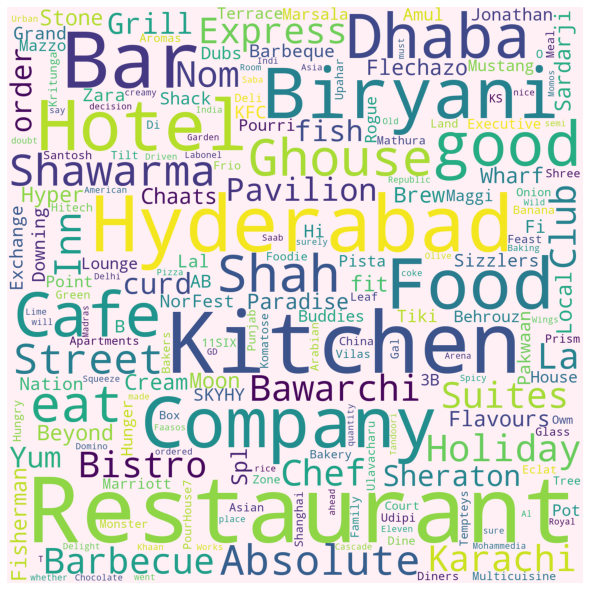

In [ ]:
#To find the most common restro names 
Rests = reviews.Restaurant.unique()
rest_string = ' '
for i in Rests:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
#!pip install spacy
import spacy

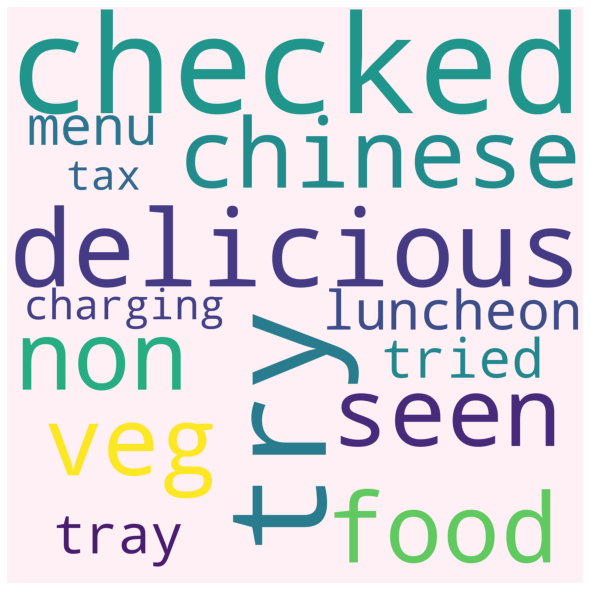

In [ ]:
nlp = spacy.blank("en")#en=English, we will only consider english words
reviews_feature = reviews['Review_Clean_String']
for review in reviews_feature:
    doc = nlp(review)
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct]
rest_string = ' '
for i in words:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
import itertools
import collections
Review_Clean = list(reviews["Review_Clean"])
token_list = list(itertools.chain(*Review_Clean))
counts_no = collections.Counter(token_list)
clean_reviews = pd.DataFrame(counts_no.most_common(30),columns=['words','count'])

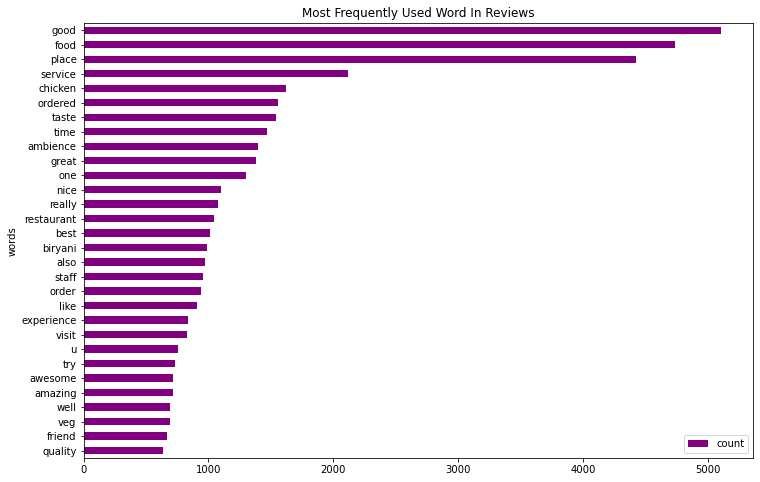

In [ ]:
fig ,ax=plt.subplots(figsize=(12,8))
clean_reviews.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")
ax.set_title("Most Frequently Used Word In Reviews")
plt.show()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(reviews.iterrows(), total=len(reviews)):
    text = row['Review_Clean_String']
    myid = row['Restaurant']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/9956 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Restaurant'})
vaders = vaders.merge(reviews, how='right')

In [ ]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...
...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...


In [ ]:
def find_polarity(rev):
    return TextBlob(rev).sentiment.polarity

In [ ]:
vaders["polarity"]=vaders["Review_Clean_String"].apply(find_polarity)

In [ ]:
for i in range(0,len(vaders["Review"])):
            print(vaders["polarity"][i])

0.6666666666666666
0.7083333333333333
0.55
0.75
0.5599999999999999
0.7999999999999999
0.25999999999999995
0.25625
0.536734693877551
0.7514285714285714
0.58
0.5125000000000001
0.5
0.7999999999999999
-0.5
0.3666666666666667
0.7
0.3678571428571429
0.675
0.7
0.3053571428571428
0.425
0.5333333333333333
0.575
0.8
0.6551948051948051
0.6590909090909091
0.6500000000000001
0.6857954545454545
0.35
-0.1802083333333333
0.85
0.5285714285714286
0.4416666666666667
0.4909090909090909
0.39999999999999997
0.1787878787878788
1.0
0.7999999999999999
0.4333333333333333
0.36704545454545456
0.6785714285714286
0.2666666666666667
0.39999999999999997
0.7150000000000001
-0.025
0.5533333333333335
0.5
0.8333333333333333
0.5523809523809523
0.6583333333333333
0.5
0.6666666666666666
0.4310204081632654
0.5458333333333333
0.3833333333333333
0.27499999999999997
0.682
0.0
0.31666666666666665
0.59
0.8
0.625
0.375
0.58
1.0
-0.42000000000000004
0.0
0.26666666666666666
0.425
0.85
0.41904761904761906
0.56875
0.42916666666666664

0.4314814814814815
0.5
0.17346938775510204
0.85
0.6499999999999999
0.7
-0.2
0.0
0.25
0.5928571428571429
-0.42499999999999993
0.6499999999999999
0.3975
0.39
0.6190476190476191
0.58
0.16999999999999998
0.4666666666666667
0.0
-0.05
0.8333333333333334
0.4875
0.0
0.4916666666666667
0.7333333333333334
0.475
0.32500000000000007
0.725
0.475
0.5625
1.0
0.5166666666666667
0.6291666666666667
0.8000000000000002
0.5166666666666667
0.8000000000000002
0.7166666666666667
0.5499999999999999
0.6238095238095237
0.7
0.7999999999999999
0.6595238095238095
0.6583333333333333
0.5222222222222223
0.7000000000000001
0.8
0.5514285714285714
0.21428571428571427
0.6
0.7000000000000001
1.0
0.55
0.7666666666666666
0.6
0.525
0.5625
0.6937500000000001
0.7333333333333334
0.4133333333333333
0.5
0.6499999999999999
1.0
0.6166666666666667
0.75
0.0
-0.6333333333333333
1.0
0.3
-0.4166666666666667
0.5357142857142858
0.6222222222222222
0.19999999999999998
0.5333333333333333
0.62
0.7
0.4680555555555556
0.5375
1.0
0.67499999999999

0.3866666666666666
0.25
0.3416666666666667
0.3875
0.5399999999999999
0.4066666666666666
0.6599999999999999
0.3166666666666667
1.0
0.0
0.925
0.8
-0.033333333333333326
0.14285714285714285
0.6875
0.6
0.012053571428571434
0.7
0.35
0.6999999999999998
0.0
0.7
0.7
0.8
0.44999999999999996
0.2
0.7
0.0
0.2
0.7
0.2
0.0
-0.23958333333333334
0.2
0.0
0.0
0.5666666666666667
0.6
0.0
0.5
-0.3
0.7
0.6
-1.0
0.6
0.7
0.26666666666666666
0.0
0.0
0.0
0.3333333333333333
0.28888888888888886
0.8
1.0
-0.2
0.7
1.0
0.7
1.0
-0.5
0.85
-0.15
0.7
-0.4708333333333333
0.7
0.7
0.7
-0.3
0.0
0.0
0.0
1.0
0.2
0.5166666666666666
-1.0
0.7
1.0
0.7
0.6
1.0
0.7
-0.1
0.7
-0.21428571428571427
0.3333333333333333
0.7
-0.3
0.54375
-0.14166666666666664
0.5035714285714286
-0.43333333333333324
-0.025
0.14444444444444446
0.10738095238095238
0.8400000000000001
-0.20833333333333331
0.0
-0.0625
-0.06666666666666667
0.04
0.3
0.21999999999999997
-0.09545454545454544
-1.0
-0.15
0.3333333333333333
-0.23750000000000002
0.14999999999999997
-0.15
0

0.0
0.0
-0.75
0.07857142857142857
0.010700757575757572
0.0
0.11666666666666665
0.2583333333333333
0.6
0.0
0.0
-0.8
-0.09999999999999992
0.7
0.0
0.33333333333333337
-0.39999999999999997
0.0
0.53125
-0.1277777777777778
-0.19166666666666668
-0.09166666666666665
0.031249999999999997
-0.6166666666666666
0.7
0.4392857142857143
-0.6499999999999999
-0.75
0.30000000000000004
0.0
-0.03333333333333336
0.0
-0.2
0.0
0.0
0.21296296296296297
0.5833333333333334
0.0
0.09999999999999999
-0.575
0.7
-0.05
0.7
0.43749999999999994
0.7
0.16
0.0
0.125
0.2733333333333333
0.0
0.0
-0.25
0.6
0.28750000000000003
0.7
0.7
0.42499999999999993
-0.16666666666666666
0.7
0.13333333333333333
0.2
0.6666666666666666
0.3
0.16
0.0
0.0
0.0
0.6
-1.0
0.0
-0.8
-0.11999999999999997
-0.3416666666666666
0.25952380952380955
0.42000000000000004
-0.0625
-0.27999999999999997
-1.0
0.0
0.0027777777777777866
-0.6
0.10952380952380952
0.7
0.03888888888888891
0.0
0.0
0.54
0.19999999999999998
0.35
0.48409090909090907
0.3207792207792208
0.75
0.

In [ ]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000
...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000


In [ ]:
vaders["classification"] = vaders["polarity"].apply(lambda x: "Positive" if x > 0 else "Negative")

In [ ]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667,Positive
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333,Positive
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000,Positive
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000,Positive
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500,Positive
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621,Positive
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000,Negative
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000,Positive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_converter = TfidfVectorizer(max_features=2000)
features = tfidf_converter.fit_transform(vaders['Review_Clean_String']).toarray()

In [ ]:
!pip install lightgbm
!pip install scikit-learn

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
target = vaders['classification']
x_train , x_test ,y_train ,y_test = train_test_split(features,target,test_size=0.3)
clf = lgb.LGBMClassifier(max_depth=20,
                        n_estimators=25,
                        min_child_weights=0.0016,
                        n_jobs=-1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Test data Accuracy is:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

[LightGBM] [Warning] Unknown parameter: min_child_weights
Test data Accuracy is: 0.920656176765986
              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87       902
    Positive       0.95      0.93      0.94      2085

    accuracy                           0.92      2987
   macro avg       0.90      0.91      0.91      2987
weighted avg       0.92      0.92      0.92      2987



<AxesSubplot:>

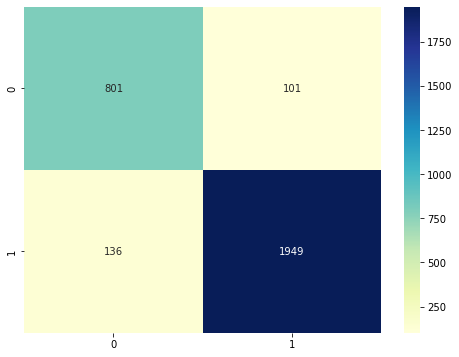

In [ ]:
cm = confusion_matrix(y_test,pred)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

In [ ]:
vaders["nb_words"] = vaders["Review_Clean_String"].apply(lambda x: len(x.split(" ")))

In [ ]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667,Positive,9
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333,Positive,14
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000,Positive,19
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000,Positive,14
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000,Positive,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500,Positive,31
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621,Positive,32
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000,Negative,10
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000,Positive,8


In [ ]:
vaders[vaders["nb_words"]>= 5].sort_values("polarity", ascending = False)[["Review_Clean_String","classification","Restaurant"]].head(100)

,Review_Clean_String,classification,Restaurant
3352,place awesome compare nearby restaurant gachib...,Positive,Club Rogue
8990,one best place chill friend people visit place...,Positive,Arena Eleven
3199,went place weekday also found place crowd perf...,Positive,Marsala Food Company
2200,best place want see sport screening,Positive,B-Dubs
754,one best shawarma joint hyderabad,Positive,Shah Ghouse Spl Shawarma
...,...,...,...
2418,dj floor best part skyhy,Positive,SKYHY
37,food ordered banjara tangdi starter best among...,Positive,Beyond Flavours
7207,best brownie cupcake town chocolatey feel get ...,Positive,Labonel
4821,best coconut chutney sambhar town pick food it...,Positive,Udipi's Upahar


In [ ]:
vaders[vaders["nb_words"] >= 5].sort_values("polarity", ascending = True)[["Review_Clean_String","classification","Restaurant"]].head(10)

,Review_Clean_String,classification,Restaurant
7754,horrible food noodle called starter basically ...,Negative,Squeeze @ The Lime
826,horrible food variety wanted give zero star,Negative,Hyper Local
8192,please refund order amount food pathetic today,Negative,Delhi-39
2150,worst dining experience ever till,Negative,Jonathan's Kitchen - Holiday Inn Express & Suites
7540,never try ulvacharu biryani worst ever,Negative,Royal Spicy Restaurant
4512,time time worst experience waiter othe worls a...,Negative,Owm Nom Nom
2882,order deliver food cancelled without notifying...,Negative,Behrouz Biryani
5371,visited place team lunch experience pathetic,Negative,Diners Pavilion
2875,ordered biriyani restaurant took close one hou...,Negative,Behrouz Biryani
4412,pathetic customer service called enquired stag...,Negative,La La Land - Bar & Kitchen


### Df2

In [ ]:
client = MongoClient('localhost',27017)
db = client.Rest
data = db.dataset_2
df2 = pd.DataFrame(list(data.find()))
df2

,_id,Restaurant,Reviewer,Rating,Restaurant_index,Reviewer_index,Rating_index
0,6329b425cb5e951178afe491,Beyond Flavours,Rusha Chakraborty,5,14.0,5430.0,0.0
1,6329b425cb5e951178afe492,Beyond Flavours,Anusha Tirumalaneedi,5,14.0,1953.0,0.0
2,6329b425cb5e951178afe493,Beyond Flavours,Ashok Shekhawat,5,14.0,2102.0,0.0
3,6329b425cb5e951178afe494,Beyond Flavours,Swapnil Sarkar,5,14.0,6759.0,0.0
4,6329b425cb5e951178afe495,Beyond Flavours,Dileep,5,14.0,354.0,0.0
...,...,...,...,...,...,...,...
9957,6329b426cb5e951178b00b76,Chinese Pavilion,Abhishek Mahajan,3,18.0,540.0,3.0
9958,6329b426cb5e951178b00b77,Chinese Pavilion,Sharad Agrawal,4.5,18.0,5977.0,5.0
9959,6329b426cb5e951178b00b78,Chinese Pavilion,Ramandeep,1.5,18.0,5127.0,8.0
9960,6329b426cb5e951178b00b79,Chinese Pavilion,Nayana Shanbhag,4,18.0,4297.0,1.0


In [ ]:
df2.isnull().sum()

_id                 0
Restaurant          0
Reviewer            0
Rating              0
Restaurant_index    0
Reviewer_index      0
Rating_index        0
dtype: int64

In [ ]:
df = df2.copy()#making a copy of the df

In [ ]:
df

,_id,Restaurant,Reviewer,Rating,Restaurant_index,Reviewer_index,Rating_index
0,6329b425cb5e951178afe491,Beyond Flavours,Rusha Chakraborty,5,14.0,5430.0,0.0
1,6329b425cb5e951178afe492,Beyond Flavours,Anusha Tirumalaneedi,5,14.0,1953.0,0.0
2,6329b425cb5e951178afe493,Beyond Flavours,Ashok Shekhawat,5,14.0,2102.0,0.0
3,6329b425cb5e951178afe494,Beyond Flavours,Swapnil Sarkar,5,14.0,6759.0,0.0
4,6329b425cb5e951178afe495,Beyond Flavours,Dileep,5,14.0,354.0,0.0
...,...,...,...,...,...,...,...
9957,6329b426cb5e951178b00b76,Chinese Pavilion,Abhishek Mahajan,3,18.0,540.0,3.0
9958,6329b426cb5e951178b00b77,Chinese Pavilion,Sharad Agrawal,4.5,18.0,5977.0,5.0
9959,6329b426cb5e951178b00b78,Chinese Pavilion,Ramandeep,1.5,18.0,5127.0,8.0
9960,6329b426cb5e951178b00b79,Chinese Pavilion,Nayana Shanbhag,4,18.0,4297.0,1.0


In [ ]:
y = df["Rating"] #  taking Rating as a dependent variable
X = df.drop(columns=["Restaurant","_id","Reviewer","Rating","Rating_index"])# taking  Review as a independent variable
X.shape

(9962, 2)

In [ ]:
X

,Restaurant_index,Reviewer_index
0,14.0,5430.0
1,14.0,1953.0
2,14.0,2102.0
3,14.0,6759.0
4,14.0,354.0
...,...,...
9957,18.0,540.0
9958,18.0,5977.0
9959,18.0,5127.0
9960,18.0,4297.0


In [ ]:
y.shape

(9962,)

In [ ]:
y


0         5
1         5
2         5
3         5
4         5
       ... 
9957      3
9958    4.5
9959    1.5
9960      4
9961    3.5
Name: Rating, Length: 9962, dtype: object

In [ ]:
y=y.replace(to_replace="Like",value=3)
y

0         5
1         5
2         5
3         5
4         5
       ... 
9957      3
9958    4.5
9959    1.5
9960      4
9961    3.5
Name: Rating, Length: 9962, dtype: object

In [ ]:
y=y.replace(to_replace="12/1/2018  9:01:00 AM",value=0)

In [ ]:
y=y.astype(float)

In [ ]:
for i in range(0,len(y)):
    if (y[i] >= 3):
        y[i] = "Positive"
    else:
        y[i] = "Negative"

In [ ]:
y

0       Positive
1       Positive
2       Positive
3       Positive
4       Positive
          ...   
9957    Positive
9958    Positive
9959    Negative
9960    Positive
9961    Positive
Name: Rating, Length: 9962, dtype: object

In [ ]:
y.unique()

array(['Positive', 'Negative'], dtype=object)

## Logistic Regression

In [ ]:
# importing all libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Train  Test  split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=2022,
                                                    stratify=y)

In [ ]:
X_train

,Restaurant_index,Reviewer_index
8604,80.0,64.0
9450,29.0,6087.0
3177,66.0,706.0
2134,44.0,5420.0
7979,61.0,5882.0
...,...,...
3074,67.0,4168.0
8079,78.0,1845.0
3957,23.0,206.0
5903,46.0,6939.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
# Building model
model = LogisticRegression(solver='sag',max_iter=10000,multi_class='ovr')

In [ ]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', solver='sag')

In [ ]:
print(model.intercept_)

[1.13137482]


In [ ]:
print(model.coef_)

[[ 0.0121583  -0.20117951]]


In [ ]:
# Prdecting model
y_pred_prob = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))


0.5969208600929209


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [ ]:
RandomForestClassifier(criterion='entropy', n_estimators=200)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [ ]:
y_pred = randomclassifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[ 204  530]
 [ 376 1879]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6968885915021746


## SVM

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[   0  734]
 [   0 2255]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7544329207092673


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2) 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[ 161  573]
 [ 324 1931]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6998996319839411


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## Collaborative Filtering

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df['Restaurant_index'] = df['Restaurant_index'].astype(int)


In [ ]:
df['Reviewer_index'] = df['Reviewer_index'].astype(int)

In [ ]:
df['Rating_index'] = df['Rating_index'].astype(int)

In [ ]:
df['Rating_index'].dtype

dtype('int32')

In [ ]:
df['Reviewer_index'].max()


7446

In [ ]:
n_users = df.Reviewer_index.unique().shape[0]
n_items = df.Restaurant_index.unique().shape[0]
df['Restaurant_index'] = df['Restaurant_index']
n_items = df['Restaurant_index'].max()
A = np.zeros((n_users,7447))
for line in df[['Restaurant_index','Reviewer_index','Rating_index']].itertuples():
    A[line[1]-1,line[2]-1] = line[3]

In [ ]:
# converting matrix into binary matrix
for i in range(len(A)):
  for j in range(len(A[0])):
    if A[i][j]>=3:
      A[i][j]=1
    else:
      A[i][j]=0

In [ ]:
# converting dense matrix into a sparse matrix using the csr_matrix() funtion 
csr_sample = csr_matrix(A)
print(csr_sample)


  (0, 71)	1.0
  (0, 79)	1.0
  (0, 285)	1.0
  (0, 349)	1.0
  (0, 376)	1.0
  (0, 398)	1.0
  (0, 542)	1.0
  (0, 901)	1.0
  (0, 1177)	1.0
  (0, 2032)	1.0
  (0, 4119)	1.0
  (0, 4390)	1.0
  (0, 6551)	1.0
  (0, 6863)	1.0
  (1, 24)	1.0
  (1, 563)	1.0
  (1, 2218)	1.0
  (1, 5492)	1.0
  (1, 6642)	1.0
  (2, 2007)	1.0
  (2, 2439)	1.0
  (2, 2548)	1.0
  (3, 0)	1.0
  (3, 47)	1.0
  (3, 77)	1.0
  :	:
  (98, 2549)	1.0
  (98, 3007)	1.0
  (98, 5381)	1.0
  (98, 5393)	1.0
  (98, 5673)	1.0
  (99, 1343)	1.0
  (7446, 3)	1.0
  (7446, 5)	1.0
  (7446, 19)	1.0
  (7446, 51)	1.0
  (7446, 118)	1.0
  (7446, 181)	1.0
  (7446, 273)	1.0
  (7446, 346)	1.0
  (7446, 403)	1.0
  (7446, 783)	1.0
  (7446, 1107)	1.0
  (7446, 1109)	1.0
  (7446, 1167)	1.0
  (7446, 1305)	1.0
  (7446, 3153)	1.0
  (7446, 3450)	1.0
  (7446, 3549)	1.0
  (7446, 5999)	1.0
  (7446, 7284)	1.0


In [ ]:
# item similarity compution
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=3)

 ## Generate Recomendations

In [ ]:
usser_id=int(input("Enter the user_id  between 0 to 7446"))

Enter the user_id  between 0 to 7446500


In [ ]:

dataset_sort_des = df.sort_values(['Reviewer_index'], ascending=[True])
filter1 = dataset_sort_des[dataset_sort_des['Reviewer_index'] == usser_id].Restaurant_index
filter1 = filter1.tolist()
filter1 = filter1[:20]
print("Items liked by user: ",filter1)

Items liked by user:  [50, 3, 52]


In [ ]:
for i in filter1:
    df_like=df.loc[df['Restaurant_index'] == i, 'Restaurant'].unique()
    print(df_like)

    

['Komatose - Holiday Inn Express & Suites']
["AB's - Absolute Barbecues"]
['La La Land - Bar & Kitchen']


In [ ]:
distances1=[]
indices1=[]
for i in filter1:
  distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=3)
  indices = indices.flatten()
  indices= indices[1:]
  indices1.extend(indices)
print("Items to be recommended: ",indices1)

Items to be recommended:  [88, 97, 50, 53, 10, 89]


In [ ]:
for i in indices1:
    df_resname=df.loc[df['Restaurant_index'] == i, 'Restaurant'].unique()
    print(df_resname)


['Tiki Shack']
['Royal Spicy Restaurant']
['Komatose - Holiday Inn Express & Suites']
['Labonel']
['Banana Leaf Multicuisine Restaurant']
['Triptify']


##Web UI Streamlit code

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english')

In [ ]:
vectors = cv.fit_transform(vaders['Review_Clean_String']).toarray()
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
cv.get_feature_names()

C:\akriti_anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['aa',
 'aaloo',
 'aalu',
 'ab',
 'aback',
 'abdul',
 'abhay',
 'abhinav',
 'abhishek',
 'able',
 'abruptly',
 'absolute',
 'absolutely',
 'abt',
 'ac',
 'accept',
 'acceptable',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessible',
 'accommodate',
 'accommodated',
 'accommodating',
 'accompanied',
 'accompaniment',
 'according',
 'accordingly',
 'account',
 'achari',
 'ache',
 'act',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'added',
 'addict',
 'addicted',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adequate',
 'adil',
 'adjacent',
 'admin',
 'administration',
 'admit',
 'admitted',
 'adraki',
 'adult',
 'advance',
 'advantage',
 'advertisement',
 'advice',
 'advise',
 'aesthetic',
 'af',
 'affect',
 'affected',
 'afford',
 'affordable',
 'afgani',
 'afghan',
 'afghani',
 'afternoon',
 'aftr',
 'age',
 'agen',
 'agent',
 'aglio',
 'ago',
 'agree',
 'agreed',
 'ah',
 'ahead',
 'ahmed',
 'air',
 'airport',
 'ajay',
 'akash'

In [ ]:
#!pip install sklearn

ERROR: Could not find a version that satisfies the requirement sklearn.metric (from versions: none)
ERROR: No matching distribution found for sklearn.metric


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)

In [ ]:
def recommend(restaurant_name):
    restaurant_index = df[df['Restaurant'] == restaurant_name].index[0]
    distances = similarity[restaurant_index]
    r_list=sorted(list(enumerate(distances)),reverse= True,key=lambda x:x[1])[1:6]
    
    for i in r_list:
        print(df.iloc[i[0]].Restaurant)

In [ ]:
recommend('Beyond Flavours')

PourHouse7
The Lal Street - Bar Exchange
10 Downing Street
Olive Garden
Flechazo


In [ ]:
import pickle

In [ ]:
df=df.drop(columns=['_id'],axis=1)


In [ ]:
#pickle.dump(df.to_dict(),open('restaurant_review_dict.pkl','wb'))

In [ ]:
#pickle.dump(similarity,open('similarity.pkl','wb'))